Cuaderno de trabajo de:
 - _Piloto_ : Nombre1 Apellido1 (username con el que os habéis logueado)
 - _Copiloto_ : Nombre2 Apellido2 [escribe el username2]

# Regresión lineal simple

Vamos a seguir el capítulo 3 del libro ["Introduction to Statistical Learning"](http://www-bcf.usc.edu/~gareth/ISL/), una elección popular escrita por protagonistas del campo, ameno de leer y que podéis descargar gratis de su página web.

El libro usa R, pero los ejemplos han sido [migrados a python](https://github.com/JWarmenhoven/ISLR-python).

En este cuaderno sólo vamos a trabajar el caso más sencillo: la "Regresión lineal simple".

- [Cargar los datos](#Cargamos-los-datos)
- [Análisis de regresión](Regresi%C3%B3n-y-ajuste-de-modelos)
- [3.1 Regresión Lineal Simple](#3.1-Regresi%C3%B3n-Lineal-Simple)
- [Ejercicios 3.1](#Ejercicios)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

## Cargamos los datos

Cargamos los conjuntos de datos que vamos a usar:

In [2]:
advertising = pd.read_csv('advertising.csv', usecols=[1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [3]:
auto = pd.read_csv('auto.csv', na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## Regresión y ajuste de modelos


El análisis de regresión consiste en encontrar un  **modelo** que relaciona los valores medidos de una variable **objetivo** (tb se llama la **respuesta**) en función de un conjunto de variables **explicativas** (tb **variables predictoras**, o **regresores**).

Los valores medidos en el mundo real nunca se ajustan de forma perfecta a un modelo, debido en primer lugar a errores de medida, pero también a que cualquier modelo matemático es una *simplificación* del mundo real, y si tuviera en cuenta todos los factores que influyen en un conjunto de variables, sería inmanejable.

Por tanto, no tiene sentido aspirar a encontrar un modelo que prediga exactamente los valores medidos, y debemos admitir que el modelo cometerá un cierto error.

Un modelo útil encuentra una relación funcional sencilla en conjuntos de pocas variables. Se trata de explicar una variable objetivo en función de otro conjunto de variables mejor conocidas o más fáciles de medir. El  **análisis de regresión**  (más exactamente, el análisis de regresión  *paramétrico*) permite encontrar un modelo explicativo en dos etapas:


 1. Nuestro conocimiento del tema en cuestión nos permite escribir un modelo que afirma que la variable  $Y$  es una función de las variables $X_1,\dots,X_p$ que podemos conocer, y de otras variables $\varepsilon_1,\dots,\varepsilon_k$ que no conocemos. La variable  $Y$ se suele llamar la **respuesta** y las variables  $X_1,\dots,X_p$ se llaman  **variables predictoras**:

$$
Y = f(X_1,\dots,X_p, \varepsilon_1,\dots,\varepsilon_k)
$$
 
 Sin embargo, no conocemos a priori la expresión de la función. En la **regresión paramétrica**, la función depende de unos pocos  **parámetros**  libres.
  
 Por ejemplo, para la **regresión lineal simple**, sólo hay una variable predictora $X$ y el modelo es
 $$
 Y = \beta_0 + \beta_1 X+ \epsilon
 $$
 donde $\beta_0,\beta_1$ son los parámetros y $\epsilon$ es un **error** que no podemos explicar dentro de este modelo, pero que asumimos que sigue una **distribución normal** y *con media 0*: 
 
$\varepsilon\sim\mathcal{N}(o,\sigma^2).$

 2. **Ajustamos el modelo** a los datos de que disponemos, eligiendo los valores de los parámetros para los que la distancia entre los valores medidos de la variable $Y$  y los valores predichos aplicando el modelo minimizan el error cometido. El error que se suele minimizar es el error cuadrático (**residual sum of squares**):
$$
RSS = e_1^2 + e_2^2 + \dots + e_n^2
$$
donde
$$
e_1 = y_1 - (\beta_0 + \beta_1 x_1), \dots e_n = y_n - (\beta_0 + \beta_1 x_n).
$$
Es decir, entre todos los posibles coeficientes $\beta_0,\beta_1$ nos quedamos con aquellos $\hat{\beta_0},\hat{\beta_1}$ que minimizan el RSS, y hemos obtenido la  **regresión lineal por mínimos cuadrados** (**least squares**).

> **Minimizar el error cuadrático** es *equivalente* a encontrar la estimación de **máxima verosimilitud** para los parámetros desconocidos $(\beta_0, \beta_1, \sigma).$

### Diferencias con un modelo probabilístico

A lo mejor os preguntáis por qué no ajustamos un modelo como una normal multivariable al conjunto de datos. El motivo es que en el modelo de regresión, *no se asume ningún modelo probabilístico para las variables predictoras*.

Esto es importante al diseñar un experimento, por ejemplo. Si para distintos valores de la velocidad medimos la resistencia, entonces las mediciones de la resistencia están sujetas a errores, pero los valores de velocidad los hemos elegido arbitrariamente, no los hemos "medido".

## 3.1 Regresión Lineal Simple

Ajustamos un modelo lineal entre dos variables:

$$
Ventas = \beta_0 + \beta_1 \times TV + \varepsilon
$$

Cada par de valores $(\beta_0, \beta_1)$ corresponde a una recta distinta.

Dibujamos la recta ajustada por mínimos cuadrados:

(0.0, 28.27)

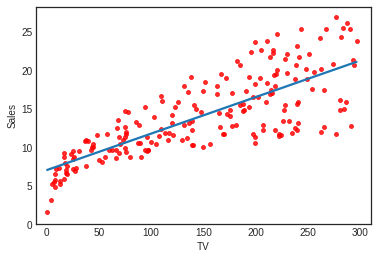

In [4]:
sns.regplot(x=advertising.TV, y=advertising.Sales, order=1, 
            ci=None, scatter_kws={'color':'r', 's':15})
plt.xlim(-10,310)
plt.ylim(ymin=0)

### scikit_learn

La librería ``scikit_learn`` es una elección popular que cubre muchos algoritmos de estadística y machine learning.
El funcionamiento de la regresión lineal es similar al de otros modelos más sofisticados:

  - 1: Definimos un objeto de tipo "LinearRegression"

```python
regr = skl_lm.LinearRegression()
```

  - 2: El método ``fit`` **"ajusta"** la recta, encontrando los valores de $(\beta_0, \beta_1)$ para los que el error cuadrático cometido es menor. Necesita dos argumentos:
      - Un **DataFrame** X con las variables predictoras. No acepta una serie, si sólo tenemos una variable predictora usamos un DataFrame con una sóla columna.
      - Una **Serie** y con la variable objetivo.

También admite arrays de numpy.

```python
X = advertising[['TV']]
y = advertising.Sales

regr.fit(X,y)
```

y ya tenemos el objeto ``regr`` que contiene la recta ajustada por mínimos cuadrados.

In [5]:
# Usamos la librería scikit_learn
regr = skl_lm.LinearRegression()

X = advertising[['TV']]
y = advertising.Sales

regr.fit(X,y)

#El objeto regr contiene los valores de los parametros
#beta0, beta1
print(regr.intercept_)
print(regr.coef_)

7.032593549127695
[0.04753664]


### Aplicar el modelo

Una vez hemos encontrado los valores de los coeficientes que mejor ajustan a los datos, podemos usar esos valores para predecir el nivel de ventas, para la inversión en TV que se ha planificado para el próximo periodo.

$$
Ventas\approx \beta_0 + \beta_1 \times TV
$$

Si usamos el modelo para predecir la respuesta ante valores de las variables predictoras que están fuera del rango de los datos de **entrenamiento** (los datos que usamos para hacer el ajuste), decimos que estamos **extrapolando**.

Con scikit-learn:

  - Podemos leer los coeficientes $(\beta_0, \beta_1)$

```python
print(regr.intercept_)  #beta0
print(regr.coef_)       #beta1
```

  - Podemos usar el modelo para predecir qué ocurrirá ante determinados valores de las variables regresoras.

```python
regr.predict([[200]])
```

In [6]:
#¿Qué ventas esperamos si la inversión en TV es de 200?
print(regr.predict([[200]]))

#¿Podemos pasar varios valores a la vez, pero tiene que
#ser un array con shape L x 1
xs = np.array([[200], [300]])
print(regr.predict(xs))

[16.53992164]
[16.53992164 21.29358568]


In [7]:
# Suele ser útil introducir los datos como un DataFrame
X = pd.DataFrame({
    'TV': [200,300]
})

regr.predict(X)

array([16.53992164, 21.29358568])

In [8]:
#Otra notación alternativa para definir un DataFrame
X = pd.DataFrame(
    [
        [200], [300]    
    ],
    columns=['TV']
)

regr.predict(X)

array([16.53992164, 21.29358568])

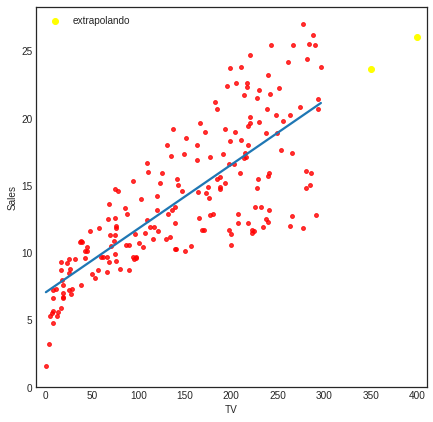

In [9]:
plt.figure(figsize=(7,7))
sns.regplot(x=advertising.TV, y=advertising.Sales, order=1, ci=None, scatter_kws={'color':'r', 's':15})
xs = np.array([[350], [400]])
plt.scatter(xs, regr.predict(xs), 
            color='yellow', 
            label='extrapolando')
plt.xlim(-10,410)
plt.ylim(ymin=0)
plt.legend(loc='upper left')
plt.show()

Como referencia, mostramos la función de dos variables que a cada par $\beta_0,\beta_1$ le asigna el RSS que comete la recta $\beta_0 + \beta_1 TV$: ¡es una función cuadrática de $\beta_0$ y $\beta_1$!

![minimizando_RSS](minimizando_RSS.png)

## Coeficientes de la recta de mínimos cuadrados
Cuando ajustamos la recta de mínimos cuadrados:
$$
Y = \beta_0 + \beta_1 X+ \epsilon
$$
los coeficientes de la recta de mínimos cuadrados son especialmente intuitivos si normalizamos las variables $X$ e $Y$:

$$
 \frac{Y-\bar{Y}}{\sigma_Y}= \text{corr}(X,Y)\frac{X-\bar{X}}{\sigma_X} + \frac{\epsilon}{\sigma_Y}
$$

## ¿Cómo decidimos si un modelo es bueno?

Supongamos que el mejor modelo lineal que hemos encontrado es $y=f(x)=\beta_0 + x\beta_1$:

 - **TSS**: Total sum of squares: $\Sigma_i (y_i-\bar{y})^2$ (sumamos el cuadrado de la diferencia entre el dato $y_i$ y la media $\bar{y}$)
 - **RSS**: Residual sum of squares:  $\Sigma_i (y_i-f(x_i))^2$ (sumamos el cuadrado de la diferencia entre el dato $y_i$ y la predicción $f(x_i)$ usando nuestro modelo)
 - **RSS/TSS**: cociente entre la "varianza residual" y la "varianza total"
 - **R-cuadrado**: "porcentaje de la varianza que el modelo explica". 
$$
R^2 = 1 - \frac{RSS}{TSS}
$$

```python
#Calcula R^2
regr.score(X,y)
```

In [10]:
X = advertising[['TV']]
y = advertising.Sales

regr.score(X,y)

0.611875050850071

El **"estadístico" $R^2$** sólo puede tomar valores entre 0 y 1:
   - Si vale 0, es que RSS=TSS, luego el modelo tiene el mismo error cuadrático total que tomar $f(x)=\bar{y}$. Es decir: _añadir el término lineal no reduce el error_.
   - Si vale 1, es que RSS=0, luego los datos se ajustan de forma "perfecta" al modelo.

> - *¿Cuándo ocurre RSS=0?*

Cuando $y_i=f(x_i) = \beta_0 + x_i\beta_1$ para cada $i$. Es decir, *cuando hay una relación lineal entre el vector $x_i$ y el vector $y_i$*. Pero sabemos que hay una relación lineal entre dos series de puntos si y sólo la correlación es 1 o -1. De hecho, *para regresión lineal simple*, $R^2$ es *exactamente* la correlación al cuadrado.

Sin embargo, veremos que para regresión lineal múltiple, el estadístico $R^2$ ofrece información que las correlaciones no aportan.

### Statsmodels 

Vamos a usar también la librería statsmodel, que imita la sintaxis de la regresión lineal en ``R``.

La fórmula ``Sales ~ TV`` significa que busca la recta de regresión
$$
Sales\approx \beta_0 + \beta_1\times TV + \varepsilon
$$

 - Ajustamos el modelo $Sales\approx \beta_0 + \beta_1\times TV + \varepsilon$ usando el DataFrame ``advertising``.
 
```python
recta = smf.ols('Sales ~ TV', advertising).fit()
```

In [11]:
#Ajustamos el modelo $Sales\approx \beta_0 + \beta_1\times TV + \varepsilon$ usando el DataFrame ``advertising``
recta = smf.ols('Sales ~ TV', advertising).fit()

 - Para predecir las ventas para uno o varios valores de inversión en TV, es necesario preparar un DataFrame que tenga una serie de datos de nombre 'TV':

```python
nuevos_datos = pd.DataFrame({
    'TV': [TV_1, ..., TV_n ]
})
recta.predict(nuevos_datos)
```

In [12]:
nuevos_datos = pd.DataFrame({
    'TV': [100,150,200,250,300,350]
})
recta.predict(nuevos_datos)

0    11.786258
1    14.163090
2    16.539922
3    18.916754
4    21.293586
5    23.670418
dtype: float64

In [13]:
recta.params

Intercept    7.032594
TV           0.047537
dtype: float64

In [14]:
recta.rsquared

0.611875050850071

#### Información extra sobre los coeficientes

stasmodels ofrece información extra sobre el resultado de la regresión.

In [15]:
recta.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

La primera fila contiene información sobre $\beta_0$ (**intercept**) y la segunda sobre $\beta_1$:
 - **coef** es la estimación del parámetro por mínimos cuadrados
 - **std err** es una medida de la incertidumbre en la estimación del parámetro
 - Las columnas **[0.025** y **0.975]** son los extremos de un "intervalo de confianza al 95%" para el valor del parámetro.
 - **t** es el valor del "t-statistic": si es bajo, quiere decir que la variable TV realmente no es de gran ayuda para predecir las ventas.
 - **P>|t|** es el *"p-valor"* asociado al valor anterior del t-estadístico. Toma valores entre 0 y 1. Un valor cercano a 1 se interpreta como *"se puede defender que Sales no depende de TV"*, y un valor cercano a 0 viene a ser *"realmente parece que TV es un buen predictor del valor de Sales"*. Un valor típico para comparar es p=0.05 o p=0.01. En este caso es aún menor.

Por favor leed las lecturas recomendadas (por ejemplo, la sección 3.1 del Introduction to Statistical Learning) para profundizar sobre estos números. La semana que viene hablaremos de ellos más despacio.

## Ejercicios


Tratamos de predecir la temperatura a la que hierve el agua ( T ), conocida la presión atmosférica ( P ) en el lugar y momento en que hacemos el experimento.

Para ello, contamos con un conjunto de mediciones de ambas variables, con la temperatura en grados Fahrenheit y la presión en pulgadas de mercurio (sea lo que sea, es una unidad de medidad de presión). Por ejemplo, en un cierto punto de los Alpes, un cierto día, el barómetro marcaba 20.79 pulgadas de mercurio, y el agua hirvió a 194.5 grados Fahrenheit. Las mediciones se realizaron en el mismo lugar geográfico, pero en días distintos, con distintas condiciones atmosféricas y quizá incluso por personas distintas. En estas condiciones, es imposible que ningún modelo prediga con exactitud el valor de T en función de P, pero esperamos que lo haga con un margen de error moderado.

$$
\begin{array}{rrrrrrrrrr}
T&194.5 & 194.3 & 197.9 & 198.4 & 199.4 & 199.9 & 200.9 & 201.1 & 201.4 & 201.3 & 203.6 & 204.6 & 209.5 & 208.6 & 210.7 & 211.9 & 212.2\\
P &20.79&  20.79&  22.4 &  22.67&  23.15&  23.35&  23.89&  23.99& 24.02&  24.01&  25.14&  26.57&  28.49&  27.76&  29.04&  29.88& 30.06
\end{array}
$$

 - Ajusta un modelo lineal a estos datos
 - Calcula el valor de $R^2$ del ajuste
 - Usa el modelo para predecir la temperatura de ebullición del agua cuando la presión es de 26 "pulgadas de mercurio".

In [16]:
datos = np.array(
        [(20.79,194.50),(20.79,194.30),(22.40,197.90),(22.67,198.40),
         (23.15,199.40),(23.35,199.90),(23.89,200.90),(23.99,201.10),
         (24.02,201.40),(24.01,201.30),(25.14,203.60),(26.57,204.60),
         (28.49,209.50),(27.76,208.60),(29.04,210.70),(29.88,211.90),
         (30.06,212.20)])

### Ejercicio 2

Consideramos los datos de coches que manejamos antes

 - Ajusta un modelo lineal a los datos de aceleración (``qsec``) conocida la potencia (``hp``) del vehículo.
 - Calcula el valor de $R^2$ del ajuste.
 - Usa el modelo para predecir la aceleración para un coche con 140 hp de potencia.
 - Añade una columna extra al DataFrame: potencia dividido por el peso (``wt``).
 - Ajusta un modelo lineal a los datos de aceleración (``qsec``) conocida la potencia/peso del vehículo: ¿Cuál es ahora el valor de $R^2$ del ajuste?

In [17]:
#Características de unos cuantos coches
mtcars=pd.read_csv('mtcars.csv')

<AxesSubplot:xlabel='hp', ylabel='qsec'>

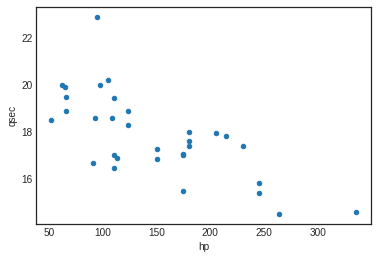

In [18]:
mtcars.plot.scatter(x='hp', y='qsec')